## Прогнозирование сердечного приступа

### Постановка задачи

В этом проекте мы создаем модель прогнозирования сердечного приступа на основе логистической регрессии.

Также выводим метрики и оценки качества модели: Accuracy, Precision, Recall, Confusion Matrix, ROC - кривую.


## Описание набора данных

Для данного проекта мы используем набор данных **Heart Data**, загруженный с сайта Kaggle

Набор содержит следующие атрибуты:

1. age: возраст в годах
2. sex: пол
    - 1: мужской
    - 0: женский
3. cp: тип боли в груди
    - 0: типичная стенокардия
    - 1: нетипичная стенокардия
    - 2: боль, не связанная со стенокардией
    - 3: бессимптомная
4. trtbps: артериальное давление в покое в мм рт.ст.
5. chol: уровень холестерина в мг/дл
6. fbs: уровень сахара в крови натощак > 120 мг/дл
    - 1: True
    - 2: False
7. restecg: результаты электрокардиографии в состоянии покоя
    - 0: норма
    - 1: аномалия зубца ST-T (инверсия зубца T и/или подъем или спад сегмента ST > 0.05 мВ)
    - 2: указывает на вероятную или определенную гипертрофию левого желудочка по критериям Эстеса
8. thalachh: максимально достигнутая частота сердечных сокращений
9. exng: стенокардия, вызванная физической нагрузкой
    - 1: да
    - 0: нет
10. oldpeak: понижение ST, вызванное физической нагрузкой, относительно покоя
11. slp: наклон сегмента ST с максимальной нагрузкой
    - 0: повышающийся
    - 1: ровный
    - 2: нисходящий
12. caa: количество крупных сосудов (0-3), окрашенных методом флуороскопии
13. thall:
    - 0: ошибка (в исходном наборе данных соответствует NaN)
    - 1: исправленный дефект
    - 2: норма
    - 3: устраняемый дефект 
14. output:
    - 0: нет заболевания
    - 1: есть заболевание

### Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Импорт данных

In [2]:
heart_data_path = 'datasets/heart_data.csv'
df = pd.read_csv(heart_data_path)

### Анализ данных

In [3]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [4]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Проверка на выбросы

<Axes: >

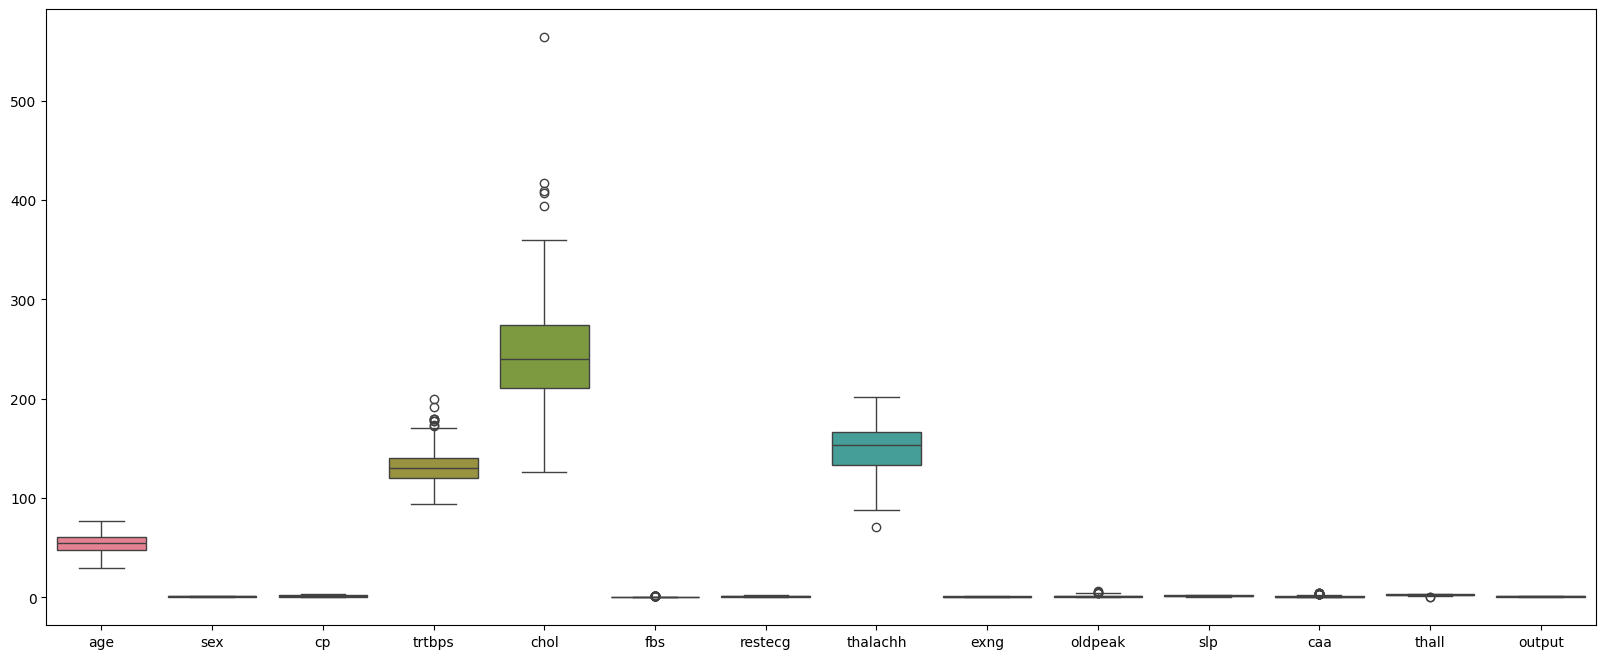

In [5]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=df)

### Удаление выбросов методом межквартильного размаха

In [6]:
for column in df.columns:
    Q1, Q3 = df[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

### Нормализация данных

In [7]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.0,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,0.517730,0.675439,0.314327,0.456198,0.486344,0.0,0.274123,0.553247,0.315789,0.236513,0.725877,0.239035,0.657895,0.578947
std,0.196362,0.469241,0.340063,0.201962,0.193580,0.0,0.258062,0.197307,0.465852,0.258856,0.293973,0.349465,0.280149,0.494814
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.340426,0.000000,0.000000,0.342105,0.343886,0.0,0.000000,0.434211,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000
50%,0.531915,1.000000,0.333333,0.473684,0.471616,0.0,0.500000,0.587719,0.000000,0.150000,0.750000,0.000000,0.500000,1.000000
75%,0.659574,1.000000,0.666667,0.605263,0.603712,0.0,0.500000,0.703947,1.000000,0.400000,1.000000,0.500000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Разделение данных на обучающую и тестовую выборку

In [8]:
X = df.drop(['output'], axis = 1)
y = df['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,  stratify=y)

### Обучение модели

In [9]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

### Прогнозирование результатов

In [10]:
y_pred = logreg.predict(X_test)

### Оценка точности

### Accuracy

In [11]:
print('Accuracy: {:.3f}'. format(accuracy_score(y_test, y_pred)))

Accuracy: 0.848


### Confusion matrix

In [12]:
print('Confusion matrix\n\n', confusion_matrix(y_test, y_pred))

Confusion matrix

 [[14  5]
 [ 2 25]]


### Precision & Recall

In [13]:
print('Precision: {:.3f}'. format(precision_score(y_test, y_pred)))
print('Recall: {:.3f}'. format(recall_score(y_test, y_pred)))

Precision: 0.833
Recall: 0.926


### F1-score

In [14]:
print('F1-score: {:.3f}'. format(f1_score(y_test, y_pred)))

F1-score: 0.877


### ROC - AUC

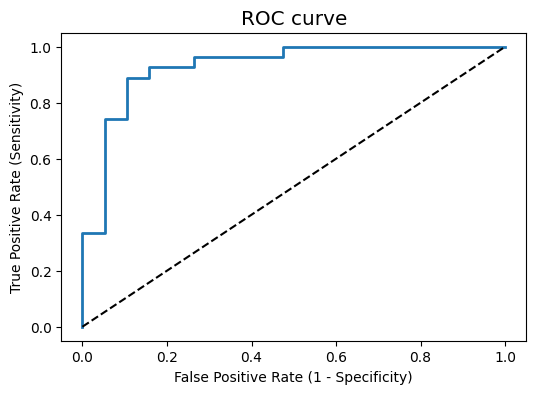

In [15]:
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

In [16]:
print('ROC AUC : {:.3f}'.format(roc_auc_score(y_test, y_pred_proba)))

ROC AUC : 0.930


### Выводы

1. Достигнутая точность составляет 84.8%, что свидетельствует о высокой общей правильности предсказаний модели. Однако точность может не быть достаточной метрикой в задачах, связанных с медицинскими прогнозами, поскольку она не учитывает дисбаланс классов.

2. Precision: 83.3%. Это показатель доли правильных предсказаний "болен" среди всех предсказаний этого класса. Высокое значение говорит о том, что модель редко ошибается в диагнозе "болен".

3. Recall: 92.6%. Это ключевая метрика для данной задачи, так как она показывает, какая доля реальных больных была правильно выявлена. Высокий Recall особенно важен в медицине, где пропуск больного пациента может привести к серьезным последствиям.

4. F1-Score: 87.7%. Сбалансированная метрика, учитывающая Precision и Recall. Она подтверждает, что модель хорошо справляется с классификацией.

5. Значение ROC AUC говорит о том, что модель уверенно разделяет классы "болен" и "здоров". Это подтверждает, что алгоритм обладает высоким уровнем дискриминации.

Для задачи прогнозирования сердечного приступа Recall является наиболее важной метрикой, так как пропуск больного пациента может привести к несвоевременной диагностике и отсутствию необходимого лечения, что опасно для жизни. Даже если модель иногда ошибочно классифицирует здорового пациента как больного, это менее критично, так как дальнейшее медицинское обследование позволит уточнить диагноз.